In [1]:
from time import sleep
import Pyro5.api 
import matplotlib.pyplot as plt
from TimeTagger import *
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

In [16]:
file = r'\\server\groups\ding\PROJECTS\QKD_Perovskites\StabilityOvernight_Receiver\20251111\TimeTags_Stability_12h_2025-11-11_181448.ttbin'
file = r'\\server\groups\ding\PROJECTS\QKD_Perovskites\StabilityOvernight_Receiver\20251111\TimeTags_Background_2025-11-12_094528.ttbin' #Background measurement file

print(file)

\\server\groups\ding\PROJECTS\QKD_Perovskites\StabilityOvernight_Receiver\20251111\TimeTags_Background_2025-11-12_094528.ttbin


In [17]:
# Now we are going to print all the configuration of the TT-Ultra at the moment of the measurement
fr = FileReader(file)
config = fr.getConfiguration()

for key, value in config.items():
    print(f"{key}: {value}")

channel number scheme: 2
configure version: 1
current time: 2025-11-12 09:45:28 +0100
devices: [{'PCB version': '1.7 (1)', 'minimum software version': '2.10.6', 'model': 'Time Tagger Ultra', 'serial': '22440012XD'}]
firmware version: TT-Ultra, FW 5, TS 2022-02-02 13:09:16, OK 1.46
fpga link: {'channels': [], 'enabled': False, 'interface': None}
hardware buffer size: 67108864
inputs: [{'channel': [1, -1], 'conditional filter filtered': [False, False], 'conditional filter triggers': [False, False], 'deadtime': [2000, 2000], 'delay hardware': [0, 0], 'delay software': [0, 0], 'event divider': [5, 1], 'hardware delay compensation': [552, 552], 'input hysteresis': 0, 'input impedance high': False, 'input mux': 0, 'normalization': [True, True], 'resolution': 'Standard', 'resolution rms': 8.0, 'trigger level': -0.01}, {'channel': [2, -2], 'conditional filter filtered': [False, False], 'conditional filter triggers': [False, False], 'deadtime': [2000, 2000], 'delay hardware': [0, 0], 'delay sof

In [18]:
virtual_tagger = createTimeTaggerVirtual()
virtual_tagger.getConfiguration()

ch1 = config['registered channels'][0] # first photon channel 
ch2 = config['registered channels'][1] # second photon channel 
ch3 = config['registered channels'][2] # third photon channel 
ch4 = config['registered channels'][3] # fourth photon channel 

cr = Countrate(virtual_tagger, [ch1, ch2, ch3, ch4])

virtual_tagger.setReplaySpeed(-1.0) # Speed of -1.0 will replay the data as fast as possible
virtual_tagger.replay(file, begin = 0, duration = -1) # collect data until the end 
virtual_tagger.waitForCompletion()

print(f"Rate of counts channel {ch1} (counts/sec) : {cr.getData()[0]}")
print(f"Rate of counts channel {ch2} (counts/sec) : {cr.getData()[1]}")
print(f"Rate of counts channel {ch3} (counts/sec) : {cr.getData()[2]}")
print(f"Rate of counts channel {ch4} (counts/sec) : {cr.getData()[3]}")

Rate of counts channel 1 (counts/sec) : 0.0
Rate of counts channel 2 (counts/sec) : 158.71666666666667
Rate of counts channel 3 (counts/sec) : 12.483333333333333
Rate of counts channel 4 (counts/sec) : 28.316666666666666


In [5]:
ch1 = config['registered channels'][0] # first photon channel 
ch2 = config['registered channels'][1] # second photon channel 
ch3 = config['registered channels'][2] # third photon channel 
ch4 = config['registered channels'][3] # fourth photon channel 

fr = FileReader(file)
fr_copy = FileReader(file)

n = 100000  # Number of counts to read in each iteration

countrate_ch1 = []
countrate_ch2 = []  
countrate_ch3 = []
countrate_ch4 = []
times = []

IniInterval = abs(fr_copy.getData(1).getTimestamps())
EndInterval = 0

while (fr.hasData()):

    data = fr.getData(n)
    data_copy = fr_copy.getData(n)
    ts = np.asarray(data.getTimestamps())   
    ts_copy = np.asarray(data_copy.getTimestamps())
    ch = np.asarray(data.getChannels())

    # Skip iteration if no events
    if ts.size == 0 and ts_copy.size == 0:
        continue  # nothing to process

    # If only one array is empty, use the non-empty one
    if ts.size == 0:
        EndInterval = ts_copy[-1]
    elif ts_copy.size == 0:
        EndInterval = ts[-1]
    else:
        EndInterval = (abs(ts[-1] + ts_copy[-1])) / 2

    delta_t = abs(IniInterval - EndInterval)
    
    # --- robust per-channel extraction using boolean mask ---
    mask1 = (ch == ch1)
    mask2 = (ch == ch2)
    mask3 = (ch == ch3)
    mask4 = (ch == ch4)

    data_ch1 = ts[mask1]
    data_ch2 = ts[mask2]
    data_ch3 = ts[mask3]
    data_ch4 = ts[mask4]
    # --------------------------------------------------------

    countrate_ch1.append(len(data_ch1) / (delta_t * 1e-12))  # Convert to counts per second
    countrate_ch2.append(len(data_ch2) / (delta_t * 1e-12))  # Convert to counts per second
    countrate_ch3.append(len(data_ch3) / (delta_t * 1e-12))  # Convert to counts per second
    countrate_ch4.append(len(data_ch4) / (delta_t * 1e-12))  # Convert to counts per second
    times.append((abs(IniInterval + EndInterval)/2) * 1e-12)  # Convert to seconds

    IniInterval = IniInterval + delta_t # Update for next iteration

times_hist = np.array(times - times[0]) #Convert to numpy array and set initial time to zero

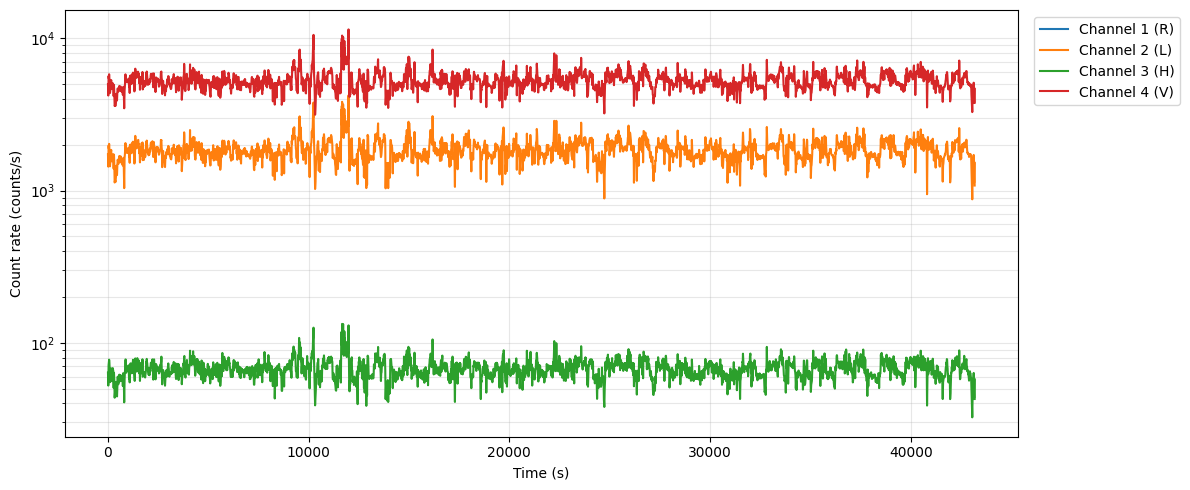

In [12]:
plt.figure(figsize=(12,5))
plt.plot(times_hist, countrate_ch1, label='Channel 1 (R)')
plt.plot(times_hist, countrate_ch2, label='Channel 2 (L)')
plt.plot(times_hist, countrate_ch3, label='Channel 3 (H)')
plt.plot(times_hist, countrate_ch4, label='Channel 4 (V)')

plt.xlabel('Time (s)')
plt.ylabel('Count rate (counts/s)')
plt.yscale('log')  # logarithmic y-axis

# Place legend outside the plot (upper right)
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))

plt.grid(True, alpha=0.3, which='both')  # show grid for log scale
plt.tight_layout()
plt.show()

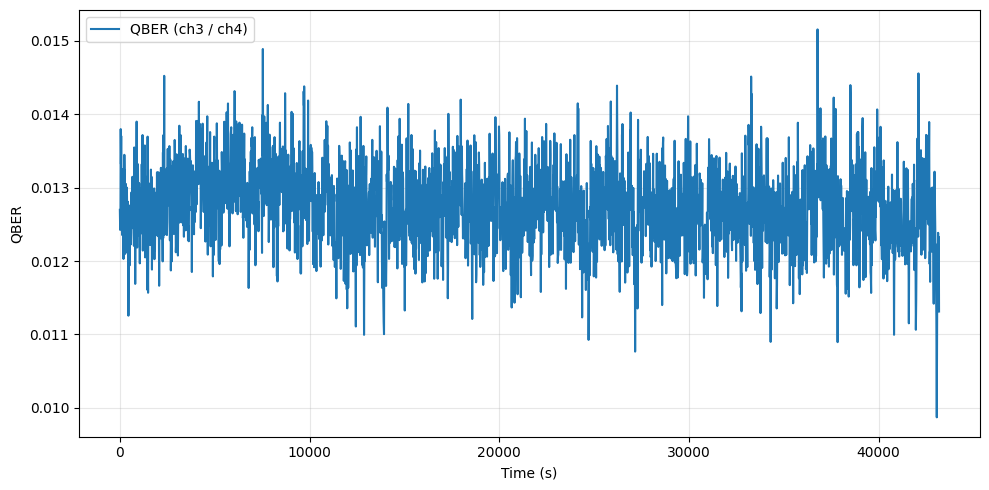

In [23]:
# Calculate QBER safely (avoid division by zero)
QBER = np.divide(countrate_ch3, countrate_ch4, out=np.zeros_like(countrate_ch3), where=countrate_ch4 != 0)

# Plot QBER vs time
plt.figure(figsize=(10,5))
plt.plot(times_hist, QBER, label='QBER (ch3 / ch4)')
plt.xlabel('Time (s)')
plt.ylabel('QBER')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()